# Quickstart

## Preparing a spectral `datacube` object

Let's initialise a `datacube` instance that will store the wavelength and flux.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from redcross import Datacube, CCF, KpV, Planet, Template

### Load data
We load an example file containing a set of HARPS-N frames and 9 of the central orders (33 to 41).


To follow the example: download the FITS file from [link](https://drive.google.com/file/d/11PXWq87yEY0V4mHeyY5JtBMnivWHIZ55/view?usp=sharing) and place it in `data_dir`.
Or load your own data containing a *wavelength* vector (nOrders, nPixels) and a *flux* vector with shape 
(nOrders, nFrames, nPixels).

In [2]:
data_dir = 'data/'
file = data_dir + 'example_harpsn33_42.fits'

with fits.open(file) as hdul:
    wave = hdul[1].data
    flux = hdul[2].data
    header = hdul[3].data # this will be used in the Cross-Correlation section
print('--Shape-- \n Wave = {:} \n Flux = {:}\n--------'.format(wave.shape, flux.shape))
print('{:} orders, {:} files, {:} pixel channels\n'.format(*flux.shape))
dc = Datacube(wlt=wave, flux=flux)


--Shape-- 
 Wave = (9, 4096) 
 Flux = (9, 247, 4096)
--------
9 orders, 247 files, 4096 pixel channels



### Display all orders
For each order, plot the master spectrum. Order 0 corresponds to order 33/69 of HARPS-N.

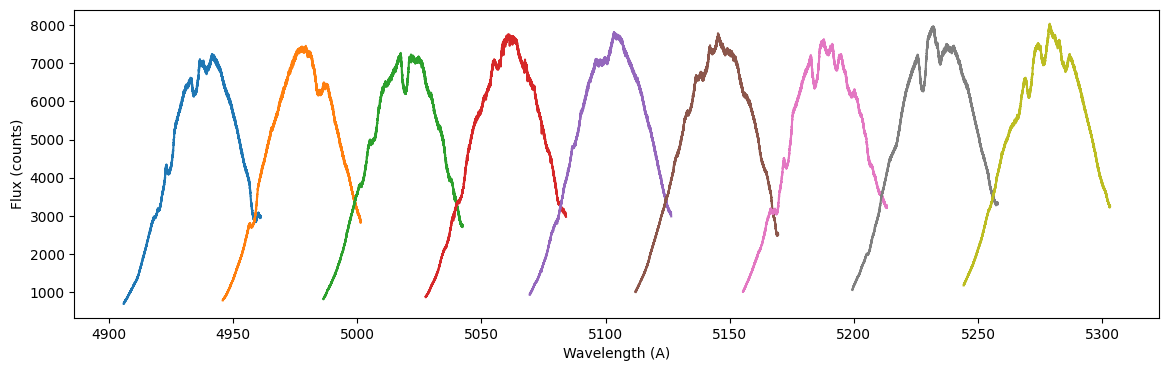

In [3]:
fig, ax = plt.subplots(1, figsize=(14,4))
for o in range(dc.nOrders):
    dco = dc.order(o).plot(ax=ax) # .plot() displays the time-average i.e. master-spectrum

ax.set(xlabel='Wavelength (A)', ylabel='Flux (counts)')
plt.show()

## Basic reduction
To manipulate the data, we will work with each order separately. To select an order simply call the function `datacube.order()`. Most functions accept an `ax` parameter to plot the resulting single-order `datacube`.

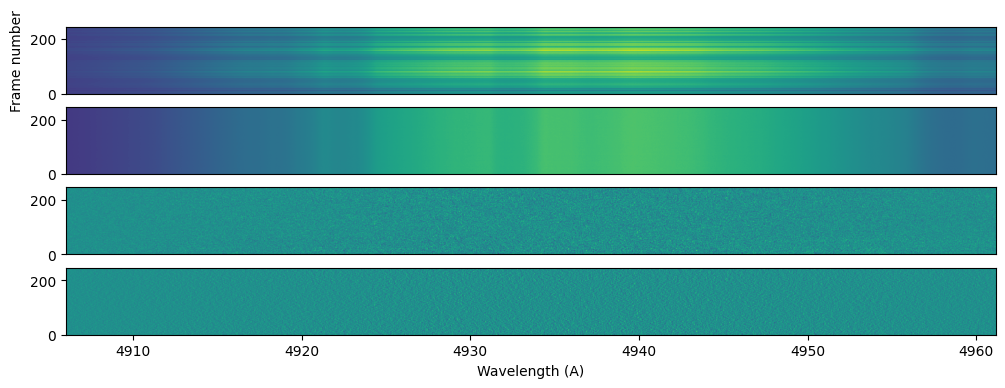

In [4]:
dco = dc.order(0)

fig, ax = plt.subplots(4, figsize=(12, 4))
dco.imshow(ax=ax[0])
dco.normalise(ax=ax[1]) # divide each frame by its mean value
dco.sysrem(5, ax=ax[2]) # run `n` iterations of the SysRem algorithm
dco.high_pass_gaussian(window=15, ax=ax[3]) # remove low-freq signal

[ax[i].set_xticks([]) for i in range(len(ax)-1)]
ax[0].set(ylabel='Frame number')
ax[len(ax)-1].set(xlabel='Wavelength (A)')
plt.show()

Now let's loop over all orders, the steps applied above can be concatenated in a single line

In [5]:
nOrders = dc.shape[0]
for order in range(nOrders):
    print('Order {:}/{:}'.format(o, nOrders-1), end='\r')
    dco = dc.order(order) # select order
    dco.normalise().sysrem(5).high_pass_gaussian(15.) # apply reduction routine
    dc.update(dco, order) # save data on the original datacube (or create a copy and update that one)

Before computing the CCF, we create a *new* datacube instance with all the orders merged

In [6]:
dcm = dc.merge_orders()
print('New shape: ', dcm.shape)

New shape:  (247, 36864)


## Cross-correlation
To speed up the CCF-map we build a 2D-shifted-template matrix $S_{kj}$ with shape (nShifts, nPix), hence the CCF-map is generated in one multiplication

$$
\text{CCF}_{ik} = \frac{R_{ij}}{\sigma_{ij}^2} · S_{kj}^\mathrm{T}
$$
* $R_{ij}$ = residuals (mean subtracted)
* $\sigma_{ij}^2$ = noise on each pixel (by default is the *variance* of each pixel
* $S_{kj}$  must be *transposed* so that the dot product is over the wavelength dimension. 

The resulting CCF-matrix has shape (nFrames, nShifts), see notebook on [cross-correlation](https://redcross.readthedocs.io/en/latest/notebooks/cross_correlation.html) for more details.

### Load a template
The atmospheric template must have a *wavelength* vector in the same units as the data and the *flux* must be **normalised** (around 1.0). For this example we use the Fe template ([download here](https://github.com/DGonzalezPicos/redcross/blob/main/examples/data/wasp189_fe_4000k.fits)) generated with [petitRADTRANS](https://petitradtrans.readthedocs.io/en/latest/index.html).

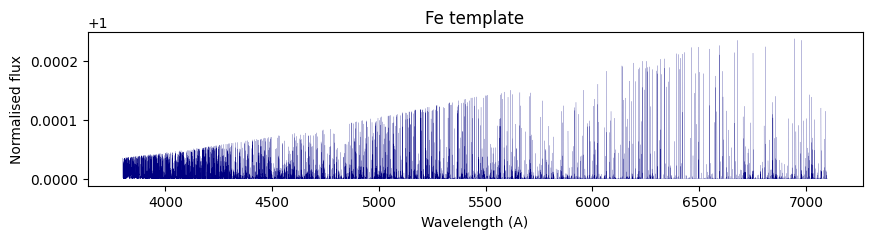

In [12]:
template_path = data_dir + 'Fe_tea_template.npy' 
twave, tflux = np.load(template_path)
    
template = Template(wlt=twave, flux=tflux).sort()

fig, ax = plt.subplots(1, figsize=(10,2))
ax.plot(template.wlt, template.flux, c='navy', lw=0.1)
ax.set(xlabel='Wavelength (A)', ylabel='Normalised flux', title='Fe template')
plt.show()

### Compute the CCF
Pass an RV-lag vector to compute the CCF at each RV, thus generating a CCF-map. The step-size of the RV should be greater (or equal) to the instrumental resolution. For HARPS-N: R ~ 115,000 ---> $\Delta$v ~ 1 km/s.

In [8]:
dRV = 1.6
RVt = np.arange(-350,351, dRV) 

# Define CCF object
ccf = CCF(rv=RVt, template=template)
ccf.run(dcm)

## Load planet data
To shift the CCF to the planetary rest-frame we need to load the planet's orbital parameters.
 1. from a file (see `WASP189.dat` for an example)

```
planet_file = 'data/wasp33.dat' 
planet = Planet(file=planet_file) 
```

### 1. from a file

```
planet_file = 'data/wasp189.dat' 
planet = Planet(file=planet_file) 
```

### 2. manually passing a dictionary

In [9]:
planet_dict = {'P':2.7240338, 'a':0.0497, 'i':84.32, 'v_sys':-20.82, 'Tc_jd':2456706.4558,
               'RA_DEG': 225.68695,'DEC_DEG': -3.0313833}
planet = Planet(**planet_dict)
planet.BERV = header.BERV
planet.MJD = header.MJD

### Shift the CCF to the planetary rest frame (PRF)
Each frame is shifted by the expected radial velocity of the planet at each time (at mid-exposure).

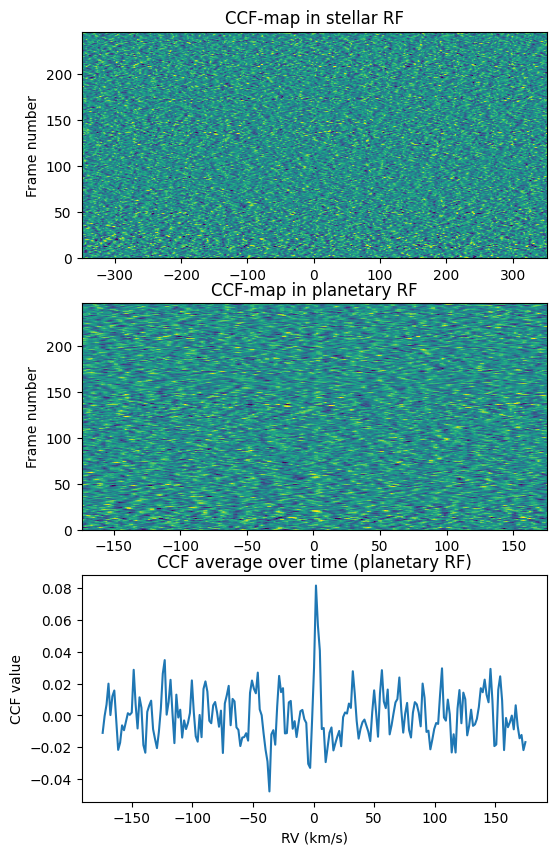

In [10]:
fig, ax = plt.subplots(3,1,figsize=(6,10))

ccf.imshow(ax=ax[0])
ccf_planet = ccf.to_planet_frame(planet, ax=ax[1])
ax[2].plot(ccf_planet.rv, np.median(ccf_planet.flux, axis=0))

ax[0].set(ylabel='Frame number', title='CCF-map in stellar RF')
ax[1].set(ylabel='Frame number', title='CCF-map in planetary RF')
ax[2].set(xlabel='RV (km/s)', ylabel='CCF value', title='CCF average over time (planetary RF)')
plt.show()

## Kp-Vsys map

This map is constructed by **adding** the values of the CCF along different paths by changing the $K_p$ and $V_{sys}$ values.
The planet signal should appear around $V_{sys} \sim $ 0 km/s if the passed $V_{sys}$ value is correct. The $K_p$ vector is automatically generated around the expected $K_p$ (with the planet orbital parameters):

$$ v_{orb} = 2\pi a / P \\ K_p = v_{orb} / \sin{i} $$

The instantaneous planet velocity is (in the **obs**erver's and **planet**'s reference frame):


$$ 
RV(t)_{obs} = V_{sys} + BERV + K_p \sin{\phi(t)} \\
RV(t)_{planet} = K_p \sin{\phi(t)} = RV(t)_{obs} - (V_{sys} + BERV)
$$ 


where $\phi$ is the phase ($\phi = 0$ at mid-transit `planet.Tc`).

Horizontal slice at Kp = 198.7 km/s
Vertical slice at Vrest = 3.2 km/s


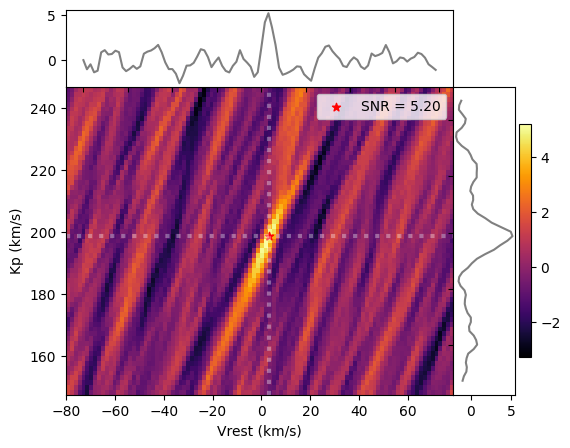

Expected planet Kp = 197.5


In [11]:
kpv = KpV(ccf, planet)
kpv.run() # compute the kpv-map values
kpv.fancy_figure() # display the map with 1D-plots
plt.show()
print('Expected planet Kp = {:.1f} km/s'.format(planet.Kp))